In [21]:
# ==============================================================
# MSc Project – Biometric Security Baseline + Adversarial Testing
# Author: Stella Williams
# Draft 4
# ==============================================================

# --------------------------------------------------------------
# Step 1: Initialise Model & Device
# --------------------------------------------------------------

import torch
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import random, cv2
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = InceptionResnetV1(pretrained="vggface2").eval().to(device)

criterion = nn.CosineEmbeddingLoss()
cos = nn.CosineSimilarity(dim=1)


Using device: cpu


In [22]:
# --------------------------------------------------------------
# Step 2: Load & Filter LFW Dataset for 2 Identities
# --------------------------------------------------------------

lfw_path = "/Users/stel/Documents/Dissertation/msc-biometric-security/Datasets/lfw-dataset"

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

lfw_full = datasets.ImageFolder(root=lfw_path, transform=transform)

# Pick 2 identities for impersonation attack
selected_classes = random.sample(lfw_full.classes, 2)
source_class, target_class = selected_classes[0], selected_classes[1]
print("Source:", source_class, "| Target:", target_class)

source_indices = [i for i, (_, label) in enumerate(lfw_full) if lfw_full.classes[label] == source_class]
target_indices = [i for i, (_, label) in enumerate(lfw_full) if lfw_full.classes[label] == target_class]

source_loader = DataLoader(Subset(lfw_full, source_indices), batch_size=1, shuffle=True)
target_loader = DataLoader(Subset(lfw_full, target_indices), batch_size=1, shuffle=True)



Source: Olivier_Rochus | Target: Padraig_Harrington


In [23]:
# --------------------------------------------------------------
# Step 3: PGD Attack for Impersonation (Targeted)
# --------------------------------------------------------------

def impersonation_pgd_v3(model, source_img, target_img, eps=0.2, alpha=0.01, steps=40):
    source_img = source_img.to(device)
    target_embed = model(target_img.to(device)).detach()
    adv = source_img.clone().detach().requires_grad_(True).to(device)

    for _ in range(steps):
        adv_embed = model(adv)
        sim = cos(adv_embed, target_embed)
        loss = -sim  # 🔁 Try direct negative cosine similarity
        model.zero_grad(); loss.backward()
        grad = adv.grad

        # Raw gradient update
        adv = adv + alpha * grad / (grad.norm() + 1e-8)
        adv = torch.clamp(source_img + torch.clamp(adv - source_img, -eps, eps), 0, 1).detach_()
        adv.requires_grad = True

    return adv




In [24]:
# --------------------------------------------------------------
# Step 4: Run One Impersonation Test (Visual + Cosine)
# --------------------------------------------------------------

source_img, _ = next(iter(source_loader))
target_img, _ = next(iter(target_loader))

adv_img = impersonation_pgd(model, source_img, target_img, eps=0.2, alpha=0.01, steps=40)

embed_src = model(source_img.to(device))
embed_tgt = model(target_img.to(device))
embed_adv = model(adv_img)

print("Cosine similarity (original vs target):", cos(embed_src, embed_tgt).item())
print("Cosine similarity (adversarial vs target):", cos(embed_adv, embed_tgt).item())




Cosine similarity (original vs target): 0.3331380784511566
Cosine similarity (adversarial vs target): -0.9768081903457642


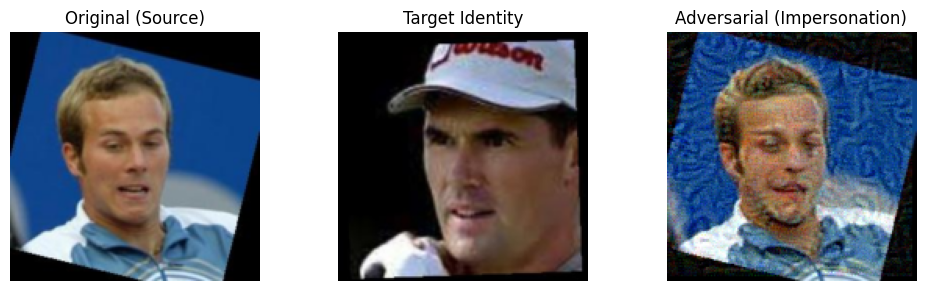

In [25]:
# --------------------------------------------------------------
# Step 5: Visualise Impersonation Attempt
# --------------------------------------------------------------

def show(img, title="Image"):
    plt.imshow(img.squeeze().permute(1,2,0).detach().cpu())
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); show(source_img, "Original (Source)")
plt.subplot(1,3,2); show(target_img, "Target Identity")
plt.subplot(1,3,3); show(adv_img, "Adversarial (Impersonation)")
plt.tight_layout()
plt.show()

